<h2> DL Lab 4
<h3> Mukul Shingwani
<h3> B20AI023

<h4> Note : I have used some of the codes given in demo colab 

## Dependancies

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
from timeit import default_timer as timer 
import os
from torch.autograd import Variable
import shutil
import glob
import time
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import verify_str_arg
from torchvision.datasets.utils import download_and_extract_archive
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1

In [ ]:
import glob
import unicodedata
import string
import torch
import random

class DataProcessor:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.all_letters = string.ascii_letters + " .,;'"
        self.n_letters = len(self.all_letters)
        self.text_files = glob.glob(f'{data_dir}/names/*.txt')
        self.category_languages = {}
        self.all_categories = []
        self.data_points = []

    def unicode_to_ascii(self, text):
        text = unicodedata.normalize('NFD', text)
        text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')
        text = text.encode('ascii', 'ignore').decode('ascii')
        text = text.strip()
        return text

    def read_lines(self, filename):
        with open(filename, 'r') as f:
            lines = f.read().strip().split('\n')
        return [self.unicode_to_ascii(line) for line in lines]

    def letter_to_tensor(self, letter):
        tensor = torch.zeros(1, self.n_letters)
        tensor[0, self.all_letters.find(letter)] = 1
        return tensor

    def line_to_tensor(self, line):
        tensor = torch.zeros(len(line), 1, self.n_letters)
        for i, letter in enumerate(line):
            tensor[i][0][self.all_letters.find(letter)] = 1
        return tensor

    def process_data(self):
        for filename in self.text_files:
            category = filename.split('/')[-1].split('.')[0]
            self.all_categories.append(category)
            languages = self.read_lines(filename)
            self.category_languages[category] = languages

        self.no_of_languages = len(self.all_categories)

        for category in self.all_categories:
            name_list = self.category_languages[category]
            labelled_name_list = [(x, category) for x in name_list]
            self.data_points += labelled_name_list

        random.shuffle(self.data_points)

        training_cut = int(len(self.data_points) * 0.8)
        val_cut = training_cut + int(len(self.data_points) * 0.1)

        self.training_samples = self.data_points[:training_cut+1]
        self.validation_samples = self.data_points[training_cut+1:val_cut+1]
        self.test_samples = self.data_points[val_cut+1:]


In [ ]:
processor = DataProcessor('/content/drive/MyDrive/Deep Learning/Lab4/data')
processor.process_data()

# Access the processed data
train_data = processor.training_samples
val_data = processor.validation_samples
test_data = processor.test_samples


In [ ]:
print('no. of languages : ',len(processor.all_categories))

no. of languages :  18


In [ ]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

16060
2007
2007


## RNN architecture

In [ ]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [ ]:
no_of_languages = len(processor.all_categories)
n_letters = len(processor.all_letters)
n_hidden = 128

In [ ]:
rnn = RNN(n_letters, n_hidden, no_of_languages)
criterion = nn.NLLLoss()
 
learning_rate = 9e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
num_epochs=10

In [ ]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) 
    category_i = top_i[0][0]
    return processor.all_categories[category_i], category_i

In [ ]:
# processor.all_categories.index('Arabic')

In [ ]:
def train(model, device, optimizer, epochs):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(1, epochs+1):
        print(f"Epoch: {epoch}")
        running_loss = 0
        correct_train = 0

        # Train loop
        model.train()
        with tqdm(total=len(train_data), desc=f'Training Epoch {epoch}/{epochs}') as pbar:
            for i, (name, lang) in enumerate(train_data):
                category_tensor = torch.tensor([processor.all_categories.index(lang)], dtype=torch.long).to(device)
                line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)

                model.zero_grad()
                hidden = model.init_hidden().to(device)

                for i in range(line_tensor.size()[0]):
                    output, hidden = model(line_tensor[i], hidden)

                loss = criterion(output, category_tensor)
                loss.backward()

                optimizer.step()
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss/(i+1))
                pbar.update(1)

                guess, _ = category_from_output(output)
                if guess == lang:
                    correct_train += 1

            train_loss.append(running_loss/len(train_data))
            train_acc.append(100 * correct_train / len(train_data))
        
        # Evaluation loop
        model.eval()
        with torch.no_grad(), tqdm(total=len(val_data), desc=f'Testing Epoch {epoch}/{epochs}') as pbar:
            running_loss = 0
            correct_test = 0
            for i, (name, lang) in enumerate(val_data):
                category_tensor = torch.tensor([processor.all_categories.index(lang)], dtype=torch.long).to(device)
                line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)

                hidden = model.init_hidden().to(device)
                for i in range(line_tensor.size()[0]):
                    output, hidden = model(line_tensor[i], hidden)

                loss = criterion(output, category_tensor)
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss/(i+1))
                pbar.update(1)

                guess, _ = category_from_output(output)
                if guess == lang:
                    correct_test += 1

            test_loss.append(running_loss/len(val_data))
            test_acc.append(100 * correct_test / len(val_data))

        # Print statistics for this epoch
        print(f"Train loss: {train_loss[-1]:.5f}, Train Acc: {train_acc[-1]:.5f} | Test loss: {test_loss[-1]:.5f}, Test acc: {test_acc[-1]:.5f}")

    return train_loss, train_acc, test_loss, test_acc

## varying hyper params

Training with learning rate 0.01
Epoch: 1


Training Epoch 1/5:   0%|          | 0/16060 [00:00<?, ?it/s]<ipython-input-13-1631c5e6452c>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/5:   0%|          | 0/2007 [00:00<?, ?it/s]<ipython-input-13-1631c5e6452c>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:07<00:00, 277.55it/s, loss=1.24e+23]


Train loss: 1345494111502460160.00000, Train Acc: 32.56538 | Test loss: 555206341436466069504.00000, Test acc: 22.12257
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:07<00:00, 266.69it/s, loss=3.98e+23]


Train loss: 3793630460975245824.00000, Train Acc: 17.13574 | Test loss: 1785639135203326164992.00000, Test acc: 9.86547
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:07<00:00, 265.26it/s, loss=6.36e+22]


Train loss: 4176445895903778304.00000, Train Acc: 10.64757 | Test loss: 285145156872388935680.00000, Test acc: 10.06477
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:07<00:00, 260.20it/s, loss=9.09e+22]


Train loss: 4135199039412817408.00000, Train Acc: 13.05106 | Test loss: 407503187318173728768.00000, Test acc: 9.96512
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:07<00:00, 261.45it/s, loss=1.86e+23]


Train loss: 4432940943396636160.00000, Train Acc: 9.90660 | Test loss: 834140524732880388096.00000, Test acc: 4.23518
Training with learning rate 0.001
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:07<00:00, 262.23it/s, loss=229]


Train loss: 1.18905, Train Acc: 64.93151 | Test loss: 1.02808, Test acc: 70.55306
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:07<00:00, 274.17it/s, loss=216]


Train loss: 0.93463, Train Acc: 71.02740 | Test loss: 0.96818, Test acc: 71.99801
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:07<00:00, 269.46it/s, loss=204]


Train loss: 0.87693, Train Acc: 72.73973 | Test loss: 0.91691, Test acc: 72.79522
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:07<00:00, 266.26it/s, loss=206]


Train loss: 0.85156, Train Acc: 73.49938 | Test loss: 0.92599, Test acc: 73.19382
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:07<00:00, 259.15it/s, loss=200]


Train loss: 0.83024, Train Acc: 73.99128 | Test loss: 0.89529, Test acc: 74.48929
Training with learning rate 0.0001
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:07<00:00, 273.74it/s, loss=289]


Train loss: 1.51982, Train Acc: 55.39228 | Test loss: 1.29691, Test acc: 63.72696
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:07<00:00, 277.20it/s, loss=252]


Train loss: 1.19175, Train Acc: 65.36115 | Test loss: 1.13036, Test acc: 68.06178
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:07<00:00, 264.77it/s, loss=230]


Train loss: 1.06105, Train Acc: 68.93524 | Test loss: 1.03287, Test acc: 71.20080
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:07<00:00, 275.57it/s, loss=215]


Train loss: 0.97523, Train Acc: 71.48817 | Test loss: 0.96619, Test acc: 72.89487
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:07<00:00, 264.44it/s, loss=205]


Train loss: 0.91455, Train Acc: 72.75218 | Test loss: 0.91850, Test acc: 74.43946
Training with learning rate 1e-05
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:07<00:00, 273.61it/s, loss=378]


Train loss: 1.90852, Train Acc: 44.46451 | Test loss: 1.69674, Test acc: 47.03538
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:07<00:00, 270.33it/s, loss=360]


Train loss: 1.66493, Train Acc: 48.66127 | Test loss: 1.61547, Test acc: 50.37369
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:07<00:00, 272.10it/s, loss=347]


Train loss: 1.59373, Train Acc: 51.54421 | Test loss: 1.55813, Test acc: 52.61584
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:07<00:00, 272.69it/s, loss=338]


Train loss: 1.54349, Train Acc: 53.51183 | Test loss: 1.51503, Test acc: 54.21026
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:07<00:00, 275.54it/s, loss=329]


Train loss: 1.50087, Train Acc: 55.10585 | Test loss: 1.47615, Test acc: 55.75486
Training with learning rate 1e-06
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:07<00:00, 281.13it/s, loss=512]


Train loss: 2.77474, Train Acc: 23.63014 | Test loss: 2.29813, Test acc: 46.58695
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:07<00:00, 279.53it/s, loss=428]


Train loss: 2.00699, Train Acc: 46.90535 | Test loss: 1.91720, Test acc: 46.63677
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:07<00:00, 261.55it/s, loss=416]


Train loss: 1.90685, Train Acc: 46.89290 | Test loss: 1.86365, Test acc: 46.63677
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:07<00:00, 271.70it/s, loss=407]


Train loss: 1.86174, Train Acc: 46.89290 | Test loss: 1.82579, Test acc: 46.63677
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:07<00:00, 278.09it/s, loss=400]


Train loss: 1.82731, Train Acc: 46.89290 | Test loss: 1.79584, Test acc: 46.63677


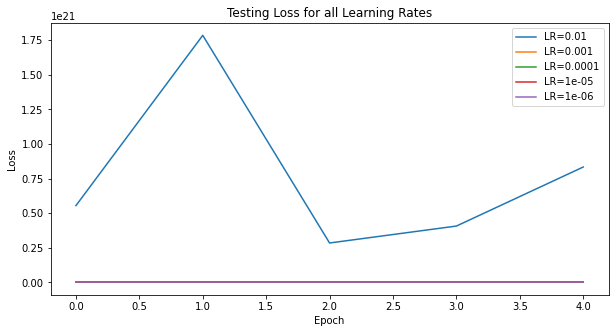

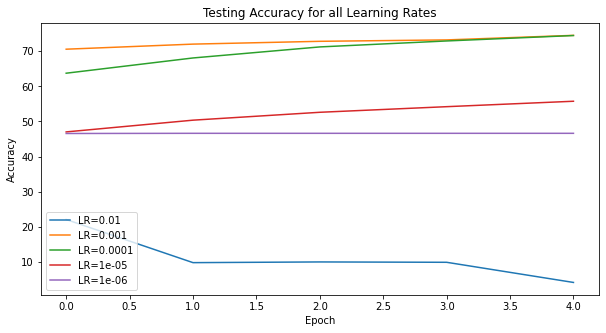

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
epochs = 5

train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []

for lr in learning_rates:
    print(f"Training with learning rate {lr}")
    model = RNN(n_letters, n_hidden, no_of_languages)
    model.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss, train_acc, test_loss, test_acc = train(model, device, optimizer, epochs)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

# Plotting the Losses for all Learning Rates
plt.figure(figsize=(10, 5))
for i in range(len(learning_rates)):
    plt.plot(test_loss_list[i], label=f"LR={learning_rates[i]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Testing Loss for all Learning Rates")
plt.legend()
plt.show()

# Plotting the Accuracies for all Learning Rates
plt.figure(figsize=(10, 5))
for i in range(len(learning_rates)):
    plt.plot(test_acc_list[i], label=f"LR={learning_rates[i]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Testing Accuracy for all Learning Rates")
plt.legend()
plt.show()


<h4> so the best learning rate seems to be in order of e-4, so training a model as per that and saving it

## training and saving the best model

In [ ]:
rnn = RNN(n_letters, n_hidden, no_of_languages)
criterion = nn.NLLLoss()
 
learning_rate = 2e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
num_epochs=10

In [ ]:
train_loss_rnn, train_acc_rnn, test_loss_rnn, test_acc_rnn = train(rnn.to(device), device, optimizer, 10)

Epoch: 1


Training Epoch 1/10:   0%|          | 0/16060 [00:00<?, ?it/s]<ipython-input-34-1631c5e6452c>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/10:   0%|          | 0/2007 [00:00<?, ?it/s]<ipython-input-34-1631c5e6452c>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/10: 100%|██████████| 2007/2007 [00:07<00:00, 264.78it/s, loss=314]


Train loss: 1.39852, Train Acc: 59.14695 | Test loss: 1.09360, Test acc: 69.95516
Epoch: 2


Testing Epoch 2/10: 100%|██████████| 2007/2007 [00:08<00:00, 248.90it/s, loss=262]


Train loss: 1.05368, Train Acc: 69.30262 | Test loss: 0.91300, Test acc: 74.63876
Epoch: 3


Testing Epoch 3/10: 100%|██████████| 2007/2007 [00:08<00:00, 239.51it/s, loss=241]


Train loss: 0.92614, Train Acc: 72.45953 | Test loss: 0.84107, Test acc: 75.73493
Epoch: 4


Testing Epoch 4/10: 100%|██████████| 2007/2007 [00:12<00:00, 157.31it/s, loss=231]


Train loss: 0.85822, Train Acc: 74.06600 | Test loss: 0.80439, Test acc: 75.88440
Epoch: 5


Testing Epoch 5/10: 100%|██████████| 2007/2007 [00:08<00:00, 232.16it/s, loss=224]


Train loss: 0.81531, Train Acc: 75.05604 | Test loss: 0.78285, Test acc: 76.38266
Epoch: 6


Testing Epoch 6/10: 100%|██████████| 2007/2007 [00:07<00:00, 265.47it/s, loss=220]


Train loss: 0.78657, Train Acc: 75.75965 | Test loss: 0.76756, Test acc: 76.93074
Epoch: 7


Testing Epoch 7/10: 100%|██████████| 2007/2007 [00:07<00:00, 273.44it/s, loss=217]


Train loss: 0.76580, Train Acc: 76.25156 | Test loss: 0.75797, Test acc: 76.78127
Epoch: 8


Testing Epoch 8/10: 100%|██████████| 2007/2007 [00:07<00:00, 270.31it/s, loss=215]


Train loss: 0.75013, Train Acc: 76.69988 | Test loss: 0.74828, Test acc: 76.78127
Epoch: 9


Testing Epoch 9/10: 100%|██████████| 2007/2007 [00:07<00:00, 266.12it/s, loss=213]


Train loss: 0.73690, Train Acc: 77.09838 | Test loss: 0.74343, Test acc: 76.98057
Epoch: 10


Testing Epoch 10/10: 100%|██████████| 2007/2007 [00:07<00:00, 275.19it/s, loss=213]

Train loss: 0.72594, Train Acc: 77.41594 | Test loss: 0.74119, Test acc: 76.88092


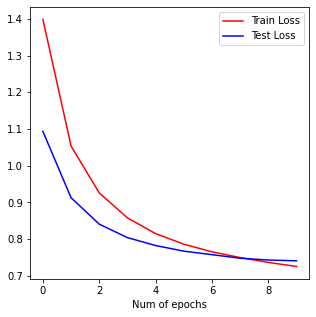

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(train_loss_rnn,'r-', label = "Train Loss")
plt.plot(test_loss_rnn, 'b-',label = "Test Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()


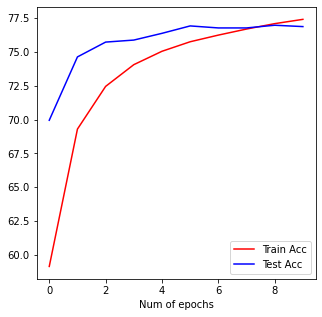

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(train_acc_rnn, 'r-',label = "Train Acc")
plt.plot(test_acc_rnn, 'b-',label = "Test Acc")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()


In [ ]:
def evaluate(model, line_tensor):
    model = model.to(device)
    hidden = model.init_hidden().to(device)
    line_tensor = line_tensor.to(device)
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    return output


## confusion matrix

<ipython-input-43-b32f128d48d2>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + processor.all_categories, rotation=90)
<ipython-input-43-b32f128d48d2>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + processor.all_categories)


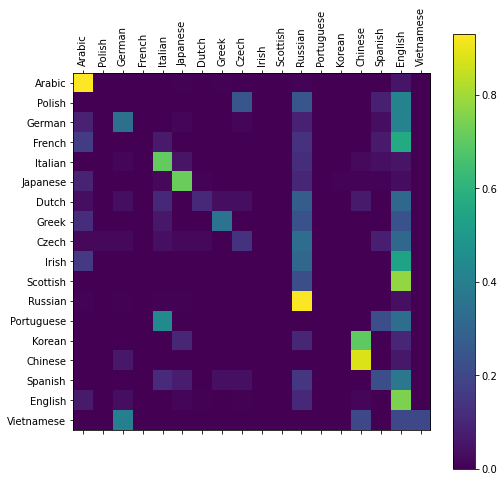

In [ ]:
confusion = torch.zeros(no_of_languages, no_of_languages)
n_confusion = 10000
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

correct = 0
with torch.no_grad():
    for (name, lang) in val_data:
        category_tensor = torch.tensor([processor.all_categories.index(lang)], dtype=torch.long)
        line_tensor = processor.line_to_tensor(name).to(device)
        output = rnn(line_tensor)
        guess, guess_i = category_from_output(output)
        if(guess == lang):
            correct+=1
        category_i = processor.all_categories.index(lang)
        confusion[category_i][guess_i] += 1

confusion = confusion / confusion.sum(dim=1, keepdim=True)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.cpu().numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + processor.all_categories, rotation=90)
ax.set_yticklabels([''] + processor.all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


<h4> saving the model

In [ ]:
torch.save(rnn.state_dict(), '/content/drive/MyDrive/Deep Learning/Lab4/rnn_best.pth')

## Part 4 : added more layers

In [ ]:
class RNN_new(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_new, self).__init__()

        self.hidden_size = hidden_size
        self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h2 = nn.Linear(hidden_size, hidden_size)
        self.i2h3 = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h1(combined)
        hidden = self.i2h2(hidden)
        hidden = self.i2h3(hidden)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [ ]:
rnn_new = RNN_new(n_letters, n_hidden, no_of_languages).to(device)
criterion = nn.NLLLoss()
 
learning_rate = 2e-4
optimizer = torch.optim.Adam(rnn_new.parameters(), lr=learning_rate)

In [ ]:
train_loss_rnn2, train_acc_rnn2, test_loss_rnn2, test_acc_rnn2 = train(rnn_new, device, optimizer, 10)

Epoch: 1


Training Epoch 1/10:   0%|          | 0/16060 [00:00<?, ?it/s]<ipython-input-34-1631c5e6452c>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/10:   0%|          | 0/2007 [00:00<?, ?it/s]<ipython-input-34-1631c5e6452c>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/10: 100%|██████████| 2007/2007 [00:08<00:00, 226.70it/s, loss=307]


Train loss: 1.19649, Train Acc: 63.87920 | Test loss: 1.07144, Test acc: 69.80568
Epoch: 2


Testing Epoch 2/10: 100%|██████████| 2007/2007 [00:08<00:00, 228.83it/s, loss=292]


Train loss: 1.06804, Train Acc: 67.48443 | Test loss: 1.01835, Test acc: 70.50324
Epoch: 3


Testing Epoch 3/10: 100%|██████████| 2007/2007 [00:08<00:00, 238.08it/s, loss=290]


Train loss: 1.02163, Train Acc: 68.91656 | Test loss: 1.01075, Test acc: 71.30045
Epoch: 4


Testing Epoch 4/10: 100%|██████████| 2007/2007 [00:08<00:00, 240.88it/s, loss=291]


Train loss: 0.99385, Train Acc: 69.67621 | Test loss: 1.01630, Test acc: 70.70254
Epoch: 5


Testing Epoch 5/10: 100%|██████████| 2007/2007 [00:08<00:00, 246.49it/s, loss=318]


Train loss: 0.97144, Train Acc: 70.20548 | Test loss: 1.10898, Test acc: 67.86248
Epoch: 6


Testing Epoch 6/10: 100%|██████████| 2007/2007 [00:08<00:00, 236.16it/s, loss=320]


Train loss: 0.95462, Train Acc: 70.52927 | Test loss: 1.11633, Test acc: 67.61335
Epoch: 7


Testing Epoch 7/10: 100%|██████████| 2007/2007 [00:08<00:00, 232.75it/s, loss=320]


Train loss: 0.93945, Train Acc: 70.90909 | Test loss: 1.11646, Test acc: 67.61335
Epoch: 8


Testing Epoch 8/10: 100%|██████████| 2007/2007 [00:08<00:00, 226.88it/s, loss=317]


Train loss: 0.92557, Train Acc: 71.33873 | Test loss: 1.10533, Test acc: 67.96213
Epoch: 9


Testing Epoch 9/10: 100%|██████████| 2007/2007 [00:08<00:00, 228.77it/s, loss=316]


Train loss: 0.91413, Train Acc: 71.78082 | Test loss: 1.10071, Test acc: 68.41056
Epoch: 10


Testing Epoch 10/10: 100%|██████████| 2007/2007 [00:08<00:00, 229.42it/s, loss=314]

Train loss: 0.90327, Train Acc: 72.15442 | Test loss: 1.09370, Test acc: 68.16143


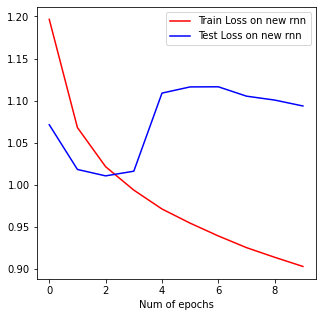

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(train_loss_rnn2,'r-', label = "Train Loss on new rnn")
plt.plot(test_loss_rnn2, 'b-',label = "Test Loss on new rnn")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()


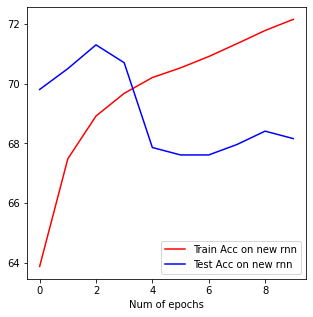

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(train_acc_rnn2, 'r-',label = "Train Acc on new rnn")
plt.plot(test_acc_rnn2, 'b-',label = "Test Acc on new rnn")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()


<ipython-input-53-29d95f42a683>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + processor.all_categories, rotation=90)
<ipython-input-53-29d95f42a683>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + processor.all_categories)


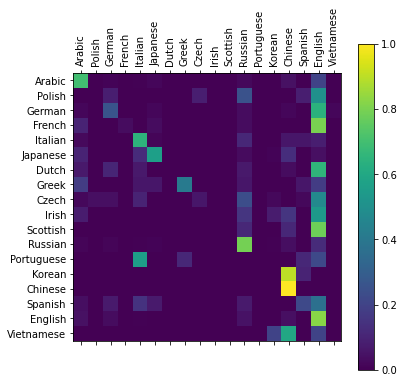

In [ ]:
confusion = torch.zeros(no_of_languages, no_of_languages)
n_confusion = 10000
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

correct = 0
with torch.no_grad():
    for (name, lang) in val_data:
        category_tensor = torch.tensor([processor.all_categories.index(lang)], dtype=torch.long)
        line_tensor = processor.line_to_tensor(name).to(device)
        output = rnn(line_tensor)
        guess, guess_i = category_from_output(output)
        if(guess == lang):
            correct+=1
        category_i = processor.all_categories.index(lang)
        confusion[category_i][guess_i] += 1

confusion = confusion / confusion.sum(dim=1, keepdim=True)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.cpu().numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + processor.all_categories, rotation=90)
ax.set_yticklabels([''] + processor.all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


Training with learning rate 0.01
Epoch: 1


Training Epoch 1/5:   0%|          | 0/16060 [00:00<?, ?it/s]<ipython-input-34-1631c5e6452c>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/5:   0%|          | 0/2007 [00:00<?, ?it/s]<ipython-input-34-1631c5e6452c>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:08<00:00, 244.02it/s, loss=2.6e+30]


Train loss: 413823373639493763001890497363968.00000, Train Acc: 7.98879 | Test loss: 9069268451270398679080501248.00000, Test acc: 7.67314
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:08<00:00, 239.80it/s, loss=2.6e+30]


Train loss: 413823574594886770930918753304576.00000, Train Acc: 7.37235 | Test loss: 9069268454067421020212428800.00000, Test acc: 7.87245
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:08<00:00, 239.85it/s, loss=2.6e+30]


Train loss: 413823579045984010306281814360064.00000, Train Acc: 7.41594 | Test loss: 9069268474933163242796613632.00000, Test acc: 7.67314
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:08<00:00, 236.84it/s, loss=2.6e+30]


Train loss: 413823579045984010306281814360064.00000, Train Acc: 7.44085 | Test loss: 9069268477821450546592088064.00000, Test acc: 7.62332
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:08<00:00, 238.06it/s, loss=2.6e+30]


Train loss: 413823579045983938248687776432128.00000, Train Acc: 7.65878 | Test loss: 9069268480715586152735703040.00000, Test acc: 7.97210
Training with learning rate 0.001
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:08<00:00, 238.35it/s, loss=366]


Train loss: 1.43329, Train Acc: 56.17061 | Test loss: 1.27540, Test acc: 61.58445
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:08<00:00, 238.42it/s, loss=966]


Train loss: 2672.56482, Train Acc: 51.41968 | Test loss: 3.36987, Test acc: 50.97160
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:08<00:00, 243.19it/s, loss=3.56e+17]


Train loss: 9839526606320699392.00000, Train Acc: 23.35616 | Test loss: 1240773380300661.75000, Test acc: 10.41355
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:08<00:00, 238.81it/s, loss=1.62e+17]


Train loss: 22719033886784638976.00000, Train Acc: 8.31258 | Test loss: 564298414685402.00000, Test acc: 6.87593
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:08<00:00, 239.36it/s, loss=8.79e+16]


Train loss: 22725737664306774016.00000, Train Acc: 8.66750 | Test loss: 306479422835880.37500, Test acc: 7.07524
Training with learning rate 0.0001
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:08<00:00, 240.81it/s, loss=331]


Train loss: 1.43394, Train Acc: 57.23537 | Test loss: 1.15467, Test acc: 67.16492
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:08<00:00, 229.23it/s, loss=298]


Train loss: 1.13179, Train Acc: 66.26401 | Test loss: 1.04000, Test acc: 70.60289
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:08<00:00, 235.19it/s, loss=288]


Train loss: 1.05142, Train Acc: 68.57410 | Test loss: 1.00307, Test acc: 71.79870
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:08<00:00, 240.94it/s, loss=281]


Train loss: 1.00629, Train Acc: 69.60772 | Test loss: 0.98006, Test acc: 72.29696
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:08<00:00, 238.78it/s, loss=277]


Train loss: 0.97598, Train Acc: 70.18680 | Test loss: 0.96504, Test acc: 73.34330
Training with learning rate 1e-05
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:08<00:00, 239.23it/s, loss=483]


Train loss: 1.81927, Train Acc: 46.82441 | Test loss: 1.68546, Test acc: 46.43747
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:16<00:00, 121.11it/s, loss=433]


Train loss: 1.63817, Train Acc: 49.97509 | Test loss: 1.50888, Test acc: 56.05381
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:09<00:00, 219.75it/s, loss=413]


Train loss: 1.51734, Train Acc: 54.69489 | Test loss: 1.44092, Test acc: 57.34928
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:08<00:00, 241.61it/s, loss=399]


Train loss: 1.46469, Train Acc: 55.91532 | Test loss: 1.39002, Test acc: 58.64474
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:08<00:00, 236.26it/s, loss=385]


Train loss: 1.41800, Train Acc: 57.38481 | Test loss: 1.34124, Test acc: 60.18934
Training with learning rate 1e-06
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:08<00:00, 240.30it/s, loss=519]


Train loss: 2.30510, Train Acc: 43.88543 | Test loss: 1.80947, Test acc: 46.43747
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:08<00:00, 239.49it/s, loss=505]


Train loss: 1.81435, Train Acc: 46.84309 | Test loss: 1.76168, Test acc: 46.43747
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:08<00:00, 235.91it/s, loss=499]


Train loss: 1.78793, Train Acc: 46.84309 | Test loss: 1.74187, Test acc: 46.43747
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:08<00:00, 230.38it/s, loss=496]


Train loss: 1.77580, Train Acc: 46.84309 | Test loss: 1.73144, Test acc: 46.43747
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:08<00:00, 237.88it/s, loss=494]


Train loss: 1.76729, Train Acc: 46.84309 | Test loss: 1.72346, Test acc: 46.43747


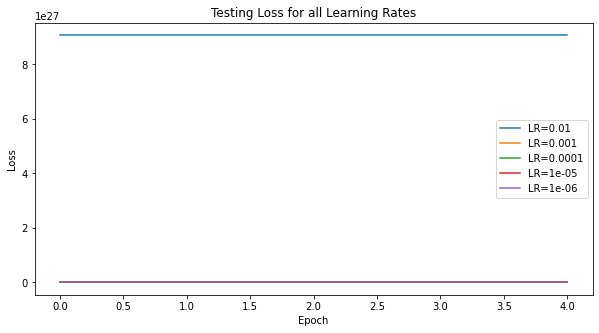

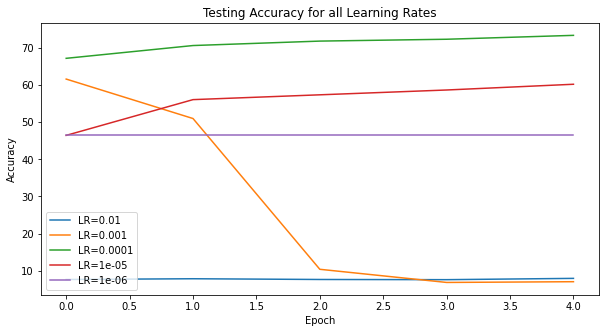

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
epochs = 5

train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []

for lr in learning_rates:
    print(f"Training with learning rate {lr}")
    model = RNN_new(n_letters, n_hidden, no_of_languages)
    model.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss, train_acc, test_loss, test_acc = train(model, device, optimizer, epochs)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

# Plotting the Losses for all Learning Rates
plt.figure(figsize=(10, 5))
for i in range(len(learning_rates)):
    plt.plot(test_loss_list[i], label=f"LR={learning_rates[i]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Testing Loss for all Learning Rates")
plt.legend()
plt.show()

# Plotting the Accuracies for all Learning Rates
plt.figure(figsize=(10, 5))
for i in range(len(learning_rates)):
    plt.plot(test_acc_list[i], label=f"LR={learning_rates[i]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Testing Accuracy for all Learning Rates")
plt.legend()
plt.show()


## Part 5 : test accuracies

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 2e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [ ]:
# Evaluation loop
model = rnn
model.eval()
with torch.no_grad(), tqdm(total=len(test_data)) as pbar:
    running_loss = 0
    correct_test = 0
    for i, (name, lang) in enumerate(test_data):
        category_tensor = torch.tensor([processor.all_categories.index(lang)], dtype=torch.long).to(device)
        line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)

        hidden = model.init_hidden().to(device)
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

        loss = criterion(output, category_tensor)
        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss/(i+1))
        pbar.update(1)

        guess, _ = category_from_output(output)
        if guess == lang:
            correct_test += 1
    print('test loss : ', running_loss/len(test_data))
    print('test accuracy : ',100 * correct_test / len(test_data),' %')

  0%|          | 0/2007 [00:00<?, ?it/s]<ipython-input-56-466834e5f350>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
100%|██████████| 2007/2007 [00:09<00:00, 211.67it/s, loss=225]

test loss :  0.7838230227481215
test accuracy :  76.18335824613851  %


In [ ]:
criterion = nn.NLLLoss()
learning_rate = 2e-4
optimizer = torch.optim.Adam(rnn_new.parameters(), lr=learning_rate)

In [ ]:
# Evaluation loop
model = rnn_new
model.eval()
with torch.no_grad(), tqdm(total=len(test_data)) as pbar:
    running_loss = 0
    correct_test = 0
    for i, (name, lang) in enumerate(test_data):
        category_tensor = torch.tensor([processor.all_categories.index(lang)], dtype=torch.long).to(device)
        line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)

        hidden = model.init_hidden().to(device)
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

        loss = criterion(output, category_tensor)
        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss/(i+1))
        pbar.update(1)

        guess, _ = category_from_output(output)
        if guess == lang:
            correct_test += 1
    print('test loss on new architecture : ', running_loss/len(test_data))
    print('test accuracy on new architecture : ',100 * correct_test / len(test_data),' %')

  0%|          | 0/2007 [00:00<?, ?it/s]<ipython-input-58-1c8b605dbe7f>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
100%|██████████| 2007/2007 [00:08<00:00, 226.62it/s, loss=324]

test loss on new architecture :  1.1306259679827795
test accuracy on new architecture :  66.01893373193822  %


<h5> The original architecture without addition of hidden layers works good for me, it gives an accuray of 76% as comapred to 66% on new architecture, with learning rate set as 2e-4 </h5>

## Part 6: Stacked RNN and word language prediction

In [ ]:
class StackedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(StackedRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.rnn_layers = nn.ModuleList([nn.RNN(input_size if layer_idx == 0 else hidden_size, hidden_size, batch_first=True) for layer_idx in range(num_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        for layer_idx, layer in enumerate(self.rnn_layers):
            output, hidden = layer(input if layer_idx == 0 else output, hidden)
        output = self.output_layer(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.num_layers, self.hidden_size)


In [ ]:
rnn_st = StackedRNN(n_letters, n_hidden, no_of_languages, 1).to(device)
criterion = nn.NLLLoss()
 
learning_rate = 2e-4
optimizer = torch.optim.Adam(rnn_st.parameters(), lr=learning_rate)

In [ ]:
train_loss_rnnSt, train_acc_rnnSt, test_loss_rnnSt, test_acc_rnnSt = train(rnn_st, device, optimizer, 10)

Epoch: 1


Training Epoch 1/10:   0%|          | 0/16060 [00:00<?, ?it/s]<ipython-input-14-1631c5e6452c>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/10:   0%|          | 0/2007 [00:00<?, ?it/s]<ipython-input-14-1631c5e6452c>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/10: 100%|██████████| 2007/2007 [00:09<00:00, 219.06it/s, loss=431]


Train loss: 1.36607, Train Acc: 61.97385 | Test loss: 1.07373, Test acc: 68.11161
Epoch: 2


Testing Epoch 2/10: 100%|██████████| 2007/2007 [00:09<00:00, 209.37it/s, loss=374]


Train loss: 1.06296, Train Acc: 69.78207 | Test loss: 0.93059, Test acc: 72.09766
Epoch: 3


Testing Epoch 3/10: 100%|██████████| 2007/2007 [00:09<00:00, 206.20it/s, loss=345]


Train loss: 0.95478, Train Acc: 72.12951 | Test loss: 0.85942, Test acc: 73.54260
Epoch: 4


Testing Epoch 4/10: 100%|██████████| 2007/2007 [00:09<00:00, 216.13it/s, loss=331]


Train loss: 0.89700, Train Acc: 73.25654 | Test loss: 0.82367, Test acc: 74.98754
Epoch: 5


Testing Epoch 5/10: 100%|██████████| 2007/2007 [00:09<00:00, 209.19it/s, loss=323]


Train loss: 0.86425, Train Acc: 74.13450 | Test loss: 0.80357, Test acc: 75.68510
Epoch: 6


Testing Epoch 6/10: 100%|██████████| 2007/2007 [00:09<00:00, 216.88it/s, loss=320]


Train loss: 0.84146, Train Acc: 74.72603 | Test loss: 0.79645, Test acc: 75.73493
Epoch: 7


Testing Epoch 7/10: 100%|██████████| 2007/2007 [00:09<00:00, 211.66it/s, loss=318]


Train loss: 0.82614, Train Acc: 75.04359 | Test loss: 0.79251, Test acc: 75.93423
Epoch: 8


Testing Epoch 8/10: 100%|██████████| 2007/2007 [00:09<00:00, 215.57it/s, loss=316]


Train loss: 0.81465, Train Acc: 75.29265 | Test loss: 0.78654, Test acc: 76.48231
Epoch: 9


Testing Epoch 9/10: 100%|██████████| 2007/2007 [00:09<00:00, 214.31it/s, loss=313]


Train loss: 0.80543, Train Acc: 75.39851 | Test loss: 0.78012, Test acc: 77.08022
Epoch: 10


Testing Epoch 10/10: 100%|██████████| 2007/2007 [00:14<00:00, 140.65it/s, loss=311]


Train loss: 0.79792, Train Acc: 75.72229 | Test loss: 0.77560, Test acc: 76.93074


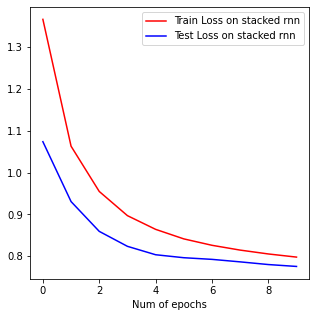

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(train_loss_rnnSt,'r-', label = "Train Loss on stacked rnn")
plt.plot(test_loss_rnnSt, 'b-',label = "Test Loss on stacked rnn")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()


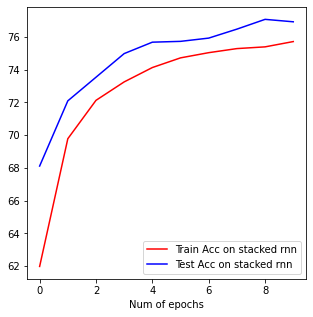

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(train_acc_rnnSt, 'r-',label = "Train Acc on stacked rnn")
plt.plot(test_acc_rnnSt, 'b-',label = "Test Acc on stacked rnn")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()


### hyperparms tuning

Training with learning rate 0.001
Epoch: 1


Training Epoch 1/5:   0%|          | 0/16060 [00:00<?, ?it/s]<ipython-input-14-1631c5e6452c>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/5:   0%|          | 0/2007 [00:00<?, ?it/s]<ipython-input-14-1631c5e6452c>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:08<00:00, 228.78it/s, loss=570]


Train loss: 1.60616, Train Acc: 59.32752 | Test loss: 1.41928, Test acc: 62.13254
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:08<00:00, 230.25it/s, loss=507]


Train loss: 1.43275, Train Acc: 63.92279 | Test loss: 1.26214, Test acc: 66.11858
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:08<00:00, 229.94it/s, loss=500]


Train loss: 1.40128, Train Acc: 64.88792 | Test loss: 1.24514, Test acc: 65.27155
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:08<00:00, 232.10it/s, loss=526]


Train loss: 1.37870, Train Acc: 65.85305 | Test loss: 1.31010, Test acc: 64.02591
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:08<00:00, 234.94it/s, loss=522]


Train loss: 1.37179, Train Acc: 66.31382 | Test loss: 1.30063, Test acc: 66.61684
Training with learning rate 0.0001
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:08<00:00, 233.51it/s, loss=468]


Train loss: 1.45434, Train Acc: 58.82939 | Test loss: 1.16547, Test acc: 66.11858
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:08<00:00, 230.21it/s, loss=411]


Train loss: 1.14290, Train Acc: 68.02615 | Test loss: 1.02377, Test acc: 70.40359
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:09<00:00, 218.55it/s, loss=374]


Train loss: 1.02696, Train Acc: 70.87796 | Test loss: 0.93217, Test acc: 72.59591
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:09<00:00, 215.58it/s, loss=349]


Train loss: 0.95042, Train Acc: 72.75841 | Test loss: 0.86846, Test acc: 74.43946
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:09<00:00, 221.96it/s, loss=333]


Train loss: 0.89668, Train Acc: 73.76090 | Test loss: 0.82897, Test acc: 75.73493
Training with learning rate 1e-05
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:08<00:00, 228.29it/s, loss=646]


Train loss: 1.86924, Train Acc: 46.98007 | Test loss: 1.60920, Test acc: 51.96811
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:08<00:00, 231.24it/s, loss=604]


Train loss: 1.59939, Train Acc: 51.86800 | Test loss: 1.50547, Test acc: 54.85800
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:09<00:00, 216.54it/s, loss=577]


Train loss: 1.51275, Train Acc: 54.55791 | Test loss: 1.43836, Test acc: 57.64823
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:09<00:00, 210.48it/s, loss=558]


Train loss: 1.45621, Train Acc: 56.61270 | Test loss: 1.39083, Test acc: 59.54160
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:09<00:00, 213.20it/s, loss=539]


Train loss: 1.40692, Train Acc: 58.98506 | Test loss: 1.34385, Test acc: 61.83358
Training with learning rate 1e-06
Epoch: 1


Testing Epoch 1/5: 100%|██████████| 2007/2007 [00:08<00:00, 229.09it/s, loss=739]


Train loss: 2.03835, Train Acc: 44.80075 | Test loss: 1.84145, Test acc: 48.03189
Epoch: 2


Testing Epoch 2/5: 100%|██████████| 2007/2007 [00:08<00:00, 229.64it/s, loss=722]


Train loss: 1.85261, Train Acc: 46.54421 | Test loss: 1.79952, Test acc: 48.03189
Epoch: 3


Testing Epoch 3/5: 100%|██████████| 2007/2007 [00:08<00:00, 229.28it/s, loss=713]


Train loss: 1.82572, Train Acc: 46.54421 | Test loss: 1.77604, Test acc: 48.03189
Epoch: 4


Testing Epoch 4/5: 100%|██████████| 2007/2007 [00:08<00:00, 223.80it/s, loss=698]


Train loss: 1.79968, Train Acc: 46.54421 | Test loss: 1.74015, Test acc: 48.03189
Epoch: 5


Testing Epoch 5/5: 100%|██████████| 2007/2007 [00:09<00:00, 220.33it/s, loss=671]


Train loss: 1.74184, Train Acc: 46.54421 | Test loss: 1.67056, Test acc: 48.03189


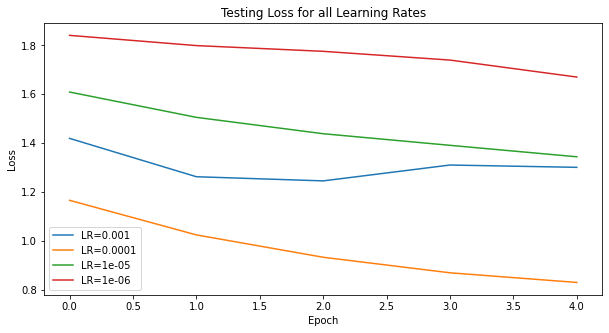

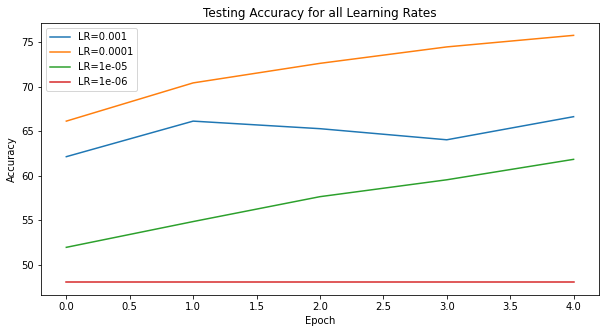

In [ ]:
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
epochs = 5

train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []

for lr in learning_rates:
    print(f"Training with learning rate {lr}")
    model = StackedRNN(n_letters, n_hidden, no_of_languages, 1).to(device)
    model.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss, train_acc, test_loss, test_acc = train(model, device, optimizer, epochs)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

# Plotting the Losses for all Learning Rates
plt.figure(figsize=(10, 5))
for i in range(len(learning_rates)):
    plt.plot(test_loss_list[i], label=f"LR={learning_rates[i]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Testing Loss for all Learning Rates")
plt.legend()
plt.show()

# Plotting the Accuracies for all Learning Rates
plt.figure(figsize=(10, 5))
for i in range(len(learning_rates)):
    plt.plot(test_acc_list[i], label=f"LR={learning_rates[i]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Testing Accuracy for all Learning Rates")
plt.legend()
plt.show()


In [ ]:
# Evaluation loop
model = rnn_st
model.eval()
with torch.no_grad(), tqdm(total=len(test_data)) as pbar:
    running_loss = 0
    correct_test = 0
    for i, (name, lang) in enumerate(test_data):
        category_tensor = torch.tensor([processor.all_categories.index(lang)], dtype=torch.long).to(device)
        line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)

        hidden = model.init_hidden().to(device)
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

        loss = criterion(output, category_tensor)
        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss/(i+1))
        pbar.update(1)

        guess, _ = category_from_output(output)
        if guess == lang:
            correct_test += 1
    print('test loss using stacked RNN : ', running_loss/len(test_data))
    print('test accuracy using stacked RNN : ',100 * correct_test / len(test_data),' %')

  0%|          | 0/2007 [00:00<?, ?it/s]<ipython-input-30-a5d6a7c50e11>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name), dtype=torch.float32).to(device)
100%|██████████| 2007/2007 [00:09<00:00, 205.85it/s, loss=407]

test loss using stacked RNN :  0.8107560941818789
test accuracy using stacked RNN :  75.63527653213752  %


At last, perform inference on the following words and print their language of origin.
<br>
Emilia, Alexandra, Sachiko, Vladimir, Minh, Xi, Muammar, Mukesh, Andrew, Ronaldo

In [ ]:
list_of_names = ['Emilia', 'Alexandra', 'Sachiko', 'Vladimir', 'Minh', 'Xi', 'Muammar', 'Mukesh', 'Andrew', 'Ronaldo']

In [ ]:
for name in list_of_names:
  line_tensor = torch.tensor(processor.line_to_tensor(name)).to(device)
  hidden = rnn_st.init_hidden().to(device)
  for i in range(line_tensor.size()[0]):
      output, hidden = rnn_st(line_tensor[i], hidden)
  guess, _ = category_from_output(output)
  print(f'name is {name} and model predicts it belongs to',guess, 'language')

name is Emilia and model predicts it belongs to Italian language
name is Alexandra and model predicts it belongs to Italian language
name is Sachiko and model predicts it belongs to Japanese language
name is Vladimir and model predicts it belongs to Russian language
name is Minh and model predicts it belongs to Russian language
name is Xi and model predicts it belongs to Chinese language
name is Muammar and model predicts it belongs to Arabic language
name is Mukesh and model predicts it belongs to Russian language
name is Andrew and model predicts it belongs to English language
name is Ronaldo and model predicts it belongs to Italian language


<ipython-input-29-9a8abc428851>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line_tensor = torch.tensor(processor.line_to_tensor(name)).to(device)


<h5> in my opinion the model is doing a good job in predicting the origin of the given words Eg: Xi as chinese, vladimir as russian. 
<br>
we have class imbalance in our dataset due to which most words if wrongly classfied are given label as english(max data)




<h5> Also stacked RNN is working almost similar to RNN (old architecture) they improve the model's capacity to capture complex temporal dependencies and improve its performance, since our dataset is small and simple it doesnt make a big diffrence